In [1]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
#from single_pendulum_task import single_pendulum_task as Task
from double_pendulum_task import double_pendulum_task as Task

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
task = Task()

K = 10000

q_list = np.zeros((2, K))

q = task.q_0.copy()
dq = np.zeros(2)
tau = np.zeros(2)
dt = 1e-3
for k in range(K):
    tau = - 30.0 * dq
    ddq = task.forward_dynamics(q.copy(), dq.copy(), tau.copy())
    dq_ = dq.copy() + dt * ddq.copy()
    q_ = q.copy() + 0.5 * dt * (dq.copy() + dq_.copy())
    q = q_.copy()
    dq = dq_.copy()
    q_list[:,k] = q.copy()

plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
plt.xlabel(r'$t$', fontsize=task.fontsize_)
plt.ylabel(r'$q$', fontsize=task.fontsize_)
plt.plot(q_list[0], lw=task.lw_)
plt.plot(q_list[1], lw=task.lw_)
plt.tight_layout()

task.save_animation(q_list.T)

### Basis functions. Providing Phi_T, Rw

Naive

In [3]:
def get_Naive_basis(nw):
    dt = task.T / (nw-1)
    t_array = np.linspace(0, task.T, nw)
    Phi = np.eye(nw)
    
    dPhi = np.zeros((nw, nw))
    for k in range(nw-1):
        dPhi[k] = (Phi[k+1] - Phi[k]) / dt
    dPhi[-1] = dPhi[-2]

    ddPhi = np.zeros((nw, nw))
    for k in range(1, nw):
        ddPhi[k] = (dPhi[k] - dPhi[k-1]) / dt
    ddPhi[0] = ddPhi[1]
    
    return np.kron(Phi, np.eye(task.ndof)), np.kron(dPhi, np.eye(task.ndof)), np.kron(ddPhi, np.eye(task.ndof))

In [4]:
nw = int(task.T / task.dt_cost) + 1
num_basis = nw - 2
Phi, dPhi, ddPhi = get_Naive_basis(nw)

task.set_basis(Phi, dPhi, ddPhi)

p_init = np.ones(num_basis*task.ndof)
for i in range(num_basis):
    p_init[i*task.ndof:(i+1)*task.ndof] = task.q_0 # np.random.uniform(q_low, q_high)

### Sequential least-squares quadratic programming

In [5]:
def fun(p):
    w = np.concatenate((task.q_0, p, task.q_d))
    return task.alpha_control * task.control_cost(w)

Xi = np.zeros((nw*task.ndof, num_basis*task.ndof))
Xi[task.ndof:-task.ndof] = np.eye(num_basis*task.ndof)
def grad(p):
    w = np.concatenate((task.q_0, p, task.q_d))
    return (task.alpha_control * task.control_grad(w)) @ Xi

def torque_con_p(p):
    w = np.concatenate((task.q_0, p, task.q_d))
    return task.inverse_dynamics(w).flatten('F')

K = len(task.t_cost_array)
    
q_min = np.zeros(task.ndof*num_basis)
q_max = np.zeros(task.ndof*num_basis)
tau_lim = np.zeros(task.ndof*K)
for i in range(task.ndof):
    q_min[i::task.ndof] = task.q_min[i] * np.ones(num_basis)
    q_max[i::task.ndof] = task.q_max[i] * np.ones(num_basis)
    tau_lim[i*K:(i+1)*K] = task.tau_lim[i] * np.ones(K)

constraints = []
constraints.append(LinearConstraint(np.eye(num_basis*task.ndof), q_min, q_max))
dq_0_off = dPhi[:task.ndof, :task.ndof] @ task.q_0 + dPhi[:task.ndof, -task.ndof:] @ task.q_d
constraints.append(LinearConstraint(dPhi[:task.ndof, task.ndof:-task.ndof],  -dq_0_off-1e-6, -dq_0_off+1e-6))
dq_T_off = dPhi[-task.ndof:, :task.ndof] @ task.q_0 + dPhi[-task.ndof:, -task.ndof:] @ task.q_d
constraints.append(LinearConstraint(dPhi[-task.ndof:, task.ndof:-task.ndof], -dq_T_off-1e-6, -dq_T_off+1e-6))
constraints.append(NonlinearConstraint(torque_con_p, -tau_lim, tau_lim))

In [6]:
start = time.time()

res = minimize(fun, p_init, method='SLSQP', jac=grad, bounds=None, constraints=constraints, options={'maxiter': 1000, 'ftol': 1e-6, 'disp': True})
#res = minimize(fun, np.concatenate((p_init, [T])), method='SLSQP', bounds=None, constraints=constraints, options={'ftol': 1e-8, 'disp': True})

duration = time.time()-start

print("Elapsed time: ", duration," [s]")

#print(res.x, get_dq_max(res.x), get_ddq_max(res.x))
w_opt = np.concatenate((task.q_0, res.x, task.q_d))

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 45.59847342972773
            Iterations: 274
            Function evaluations: 791
            Gradient evaluations: 270
Elapsed time:  478.88524746894836  [s]


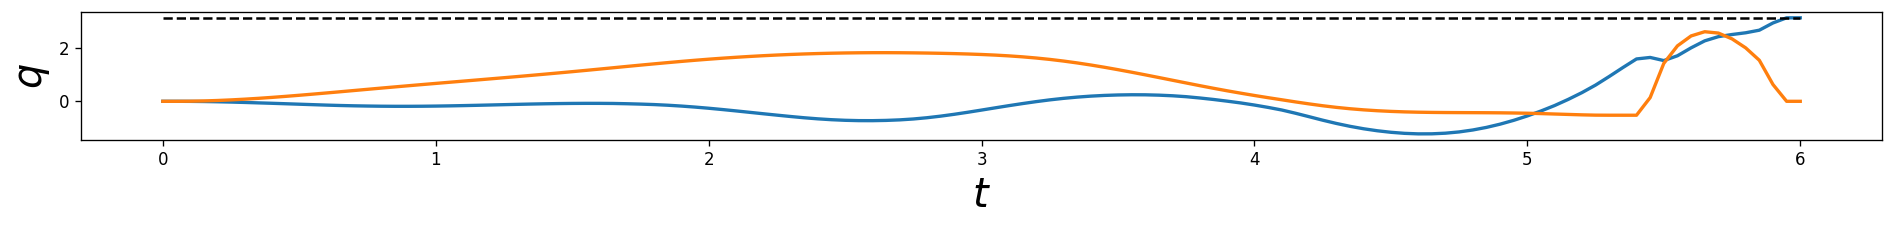

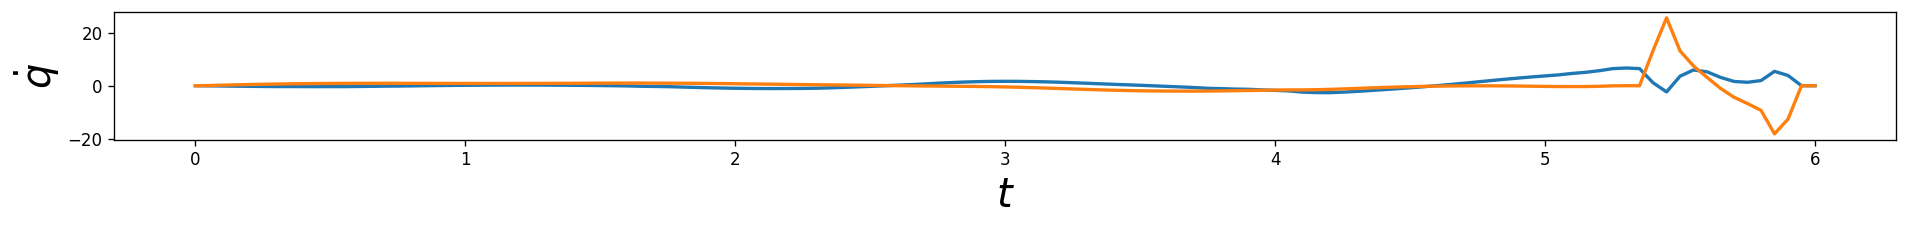

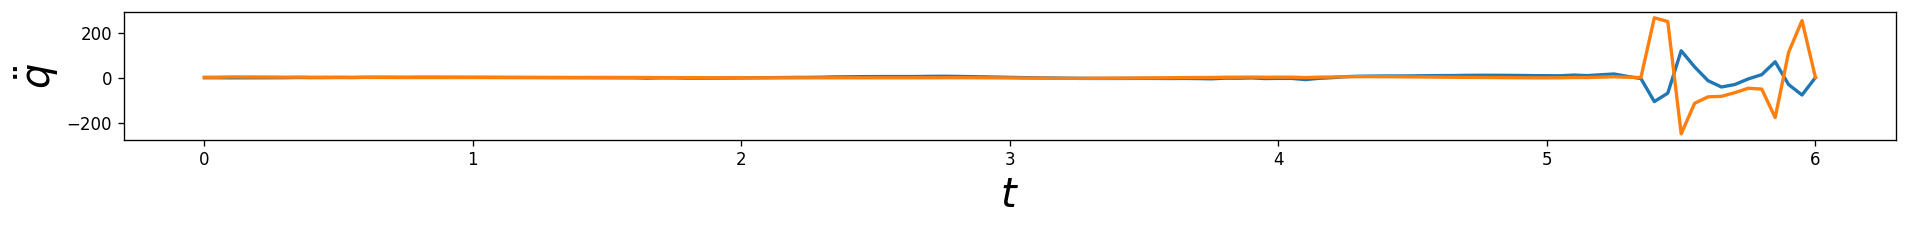

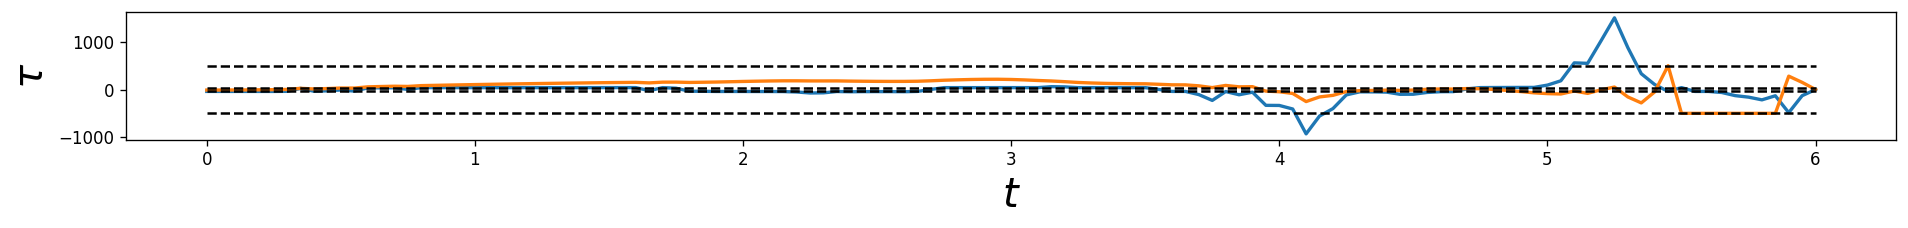

In [7]:
task.plot_q(w_opt)
task.plot_dq(w_opt)
task.plot_ddq(w_opt)
task.plot_tau(w_opt)

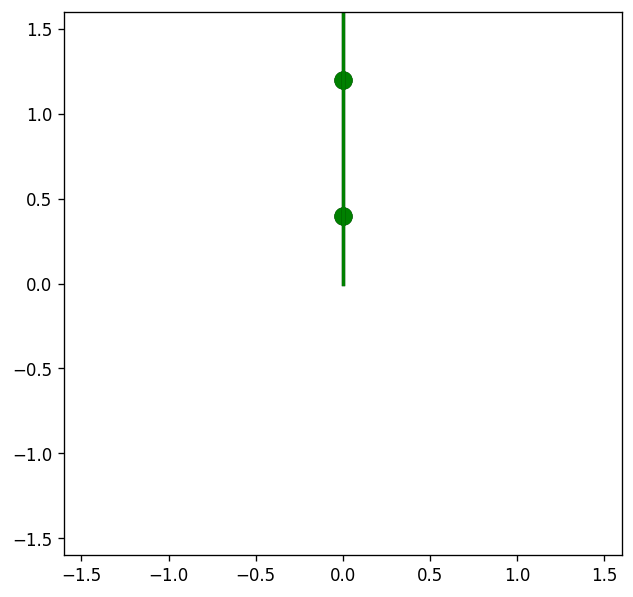

In [8]:
task.save_animation(w_opt)